In [1]:
import os, sys, time, tqdm
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scanpy as sc
import cell2location

/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/xiaojiashun

# Ref model

In [2]:
# create paths and names to results folders for reference regression and cell2location models
ref_dir = f'/data2/xiaojiashun/niche/data/lymph_nodes_analysis/reference_signatures'
data_dir = f'/data2/xiaojiashun/niche/data/Xenium/Xenium_Prime_Human_Lymph_Node_Reactive_FFPE_outs/three_crops'

In [3]:
adata_file = f"{ref_dir}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(ref_dir, adata_ref)

INFO     File /data2/xiaojiashun/niche/data/lymph_nodes_analysis/reference_signatures/model.pt already downloaded  


/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load

Epoch 1/273:   0%|▎                                                                                                | 1/273 [00:00<01:05,  4.15it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.



poch 1/273:   0%|▎                                                                                                | 1/273 [00:00<01:08,  3.98it/s, v_num=1]

In [4]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B_Cycling,B_GC_DZ,B_GC_LZ,B_GC_prePB,B_IFN
GeneID-2,,,,,
ENSG00000188976,0.600657,0.335230,0.423703,0.464863,0.203950
ENSG00000188290,0.004254,0.000849,0.001244,0.072195,0.057932
ENSG00000187608,0.399682,0.168536,0.244742,0.535174,5.261536
ENSG00000186891,0.028720,0.000989,0.074086,0.089243,0.012705
ENSG00000186827,0.011228,0.000747,0.009442,0.038227,0.013607


# Crop1

In [5]:
## xenium data
ad_sp = sc.read(f'{data_dir}/crop1_raw.h5ad')
ad_sp.var = ad_sp.var.set_index('gene_ids')
intersect = np.intersect1d(ad_sp.var_names, inf_aver.index)
ad_sp = ad_sp[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
ad_sp

AnnData object with n_obs × n_vars = 197644 × 2964
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'x', 'y', 'group'
    var: 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

## Chunk1

In [6]:
ad_sp_chunk = ad_sp[:100000].copy()
intersect = np.intersect1d(ad_sp_chunk.var_names, inf_aver.index)
ad_sp_chunk = ad_sp_chunk[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=ad_sp_chunk)
#scvi.data.view_anndata_setup(adata_vis)
# create and train the model
mod = cell2location.models.Cell2location(
    ad_sp_chunk, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=1,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=20
)
ad_sp_chunk

AnnData object with n_obs × n_vars = 100000 × 2964
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'x', 'y', 'group', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome'
    uns: 'spatialdata_attrs', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'spatial'

In [ ]:
mod.train(max_epochs=20000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the

Epoch 497/20000:   2%|█▋                                                                 | 496/20000 [02:04<1:21:34,  3.98it/s, v_num=1, elbo_train=1.01e+8]

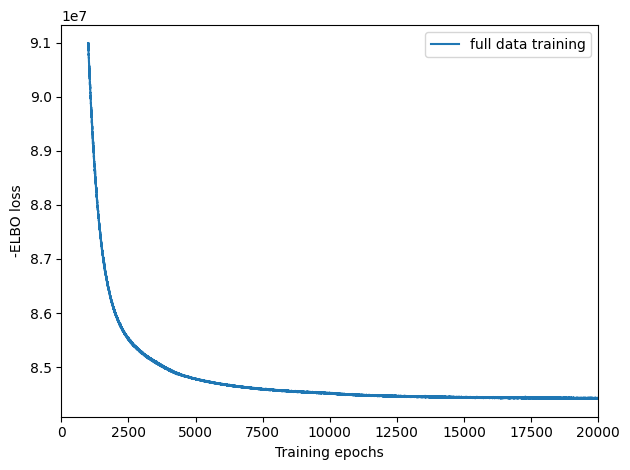

In [10]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])

In [11]:
## save trained model
mod.save(f"{data_dir}/cell2location_map_crop1_chunk1", overwrite=True)

In [12]:
## infer
ad_sp_chunk = mod.export_posterior(ad_sp_chunk, use_quantiles=True, add_to_obsm=['q05'])
q05_df = ad_sp_chunk.obsm['q05_cell_abundance_w_sf']
q05_df.columns = [x.replace('q05cell_abundance_w_sf_', '') for x in q05_df.columns]
q05 = q05_df.values
q05_norm = q05 / q05.sum(1)[:,None]
q05_ct_df = pd.DataFrame(q05_norm, columns = q05_df.columns)
q05_ct_df['cell_type'] = q05_df.columns[q05_df.values.argmax(1)]
q05_ct_df['cell_type'] = q05_ct_df['cell_type'].astype('category')
all_cts = q05_ct_df['cell_type'].cat.categories.tolist()
q05_ct_df['max_abun'] = q05.max(1)
q05_ct_df['max_norm'] = q05_norm.max(1)
q05_ct_df['x'] = ad_sp_chunk.obs['x'].values
q05_ct_df['y'] = ad_sp_chunk.obs['y'].values
q05_ct_df['cell_id'] = ad_sp_chunk.obs['cell_id'].values
q05_ct_df.set_index(ad_sp_chunk.obs.index, inplace=True)
q05_ct_df.groupby('cell_type')['max_norm'].agg(['size', 'median'])

/tmp/ipykernel_1010002/1840773302.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  q05_ct_df.groupby('cell_type')['max_norm'].agg(['size', 'median'])


,size,median
cell_type,,
B_Cycling,1855,0.331623
B_GC_DZ,1411,0.246171
B_GC_LZ,2948,0.295694
B_GC_prePB,315,0.211015
B_IFN,1263,0.260227
B_activated,416,0.202683
B_mem,9725,0.281143
B_naive,2336,0.210591
B_plasma,3137,0.438126


In [13]:
## save qc info
q05_ct_df.to_csv(f'{data_dir}/cell2location_info_crop1_chunk1.csv', sep='\t', index=True)

## Chunk2

In [6]:
ad_sp_chunk = ad_sp[100000:].copy()
intersect = np.intersect1d(ad_sp_chunk.var_names, inf_aver.index)
ad_sp_chunk = ad_sp_chunk[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=ad_sp_chunk)
#scvi.data.view_anndata_setup(adata_vis)
# create and train the model
mod = cell2location.models.Cell2location(
    ad_sp_chunk, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=1,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=20
)
ad_sp_chunk

AnnData object with n_obs × n_vars = 97644 × 2964
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'x', 'y', 'group', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome'
    uns: 'spatialdata_attrs', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'spatial'

In [7]:
mod.train(max_epochs=20000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the

Epoch 20000/20000: 100%|███████████████████████████████████████████████████████████████| 20000/20000 [1:21:49<00:00,  4.08it/s, v_num=1, elbo_train=6.15e+7]

`Trainer.fit` stopped: `max_epochs=20000` reached.



poch 20000/20000: 100%|███████████████████████████████████████████████████████████████| 20000/20000 [1:21:49<00:00,  4.07it/s, v_num=1, elbo_train=6.15e+7]

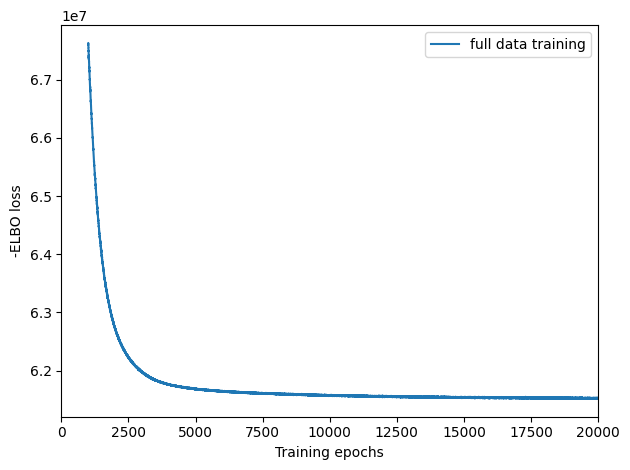

In [8]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])

In [9]:
## save trained model
mod.save(f"{data_dir}/cell2location_map_crop1_chunk2", overwrite=True)

In [10]:
## infer
ad_sp_chunk = mod.export_posterior(ad_sp_chunk, use_quantiles=True, add_to_obsm=['q05'])
q05_df = ad_sp_chunk.obsm['q05_cell_abundance_w_sf']
q05_df.columns = [x.replace('q05cell_abundance_w_sf_', '') for x in q05_df.columns]
q05 = q05_df.values
q05_norm = q05 / q05.sum(1)[:,None]
q05_ct_df = pd.DataFrame(q05_norm, columns = q05_df.columns)
q05_ct_df['cell_type'] = q05_df.columns[q05_df.values.argmax(1)]
q05_ct_df['cell_type'] = q05_ct_df['cell_type'].astype('category')
all_cts = q05_ct_df['cell_type'].cat.categories.tolist()
q05_ct_df['max_abun'] = q05.max(1)
q05_ct_df['max_norm'] = q05_norm.max(1)
q05_ct_df['x'] = ad_sp_chunk.obs['x'].values
q05_ct_df['y'] = ad_sp_chunk.obs['y'].values
q05_ct_df['cell_id'] = ad_sp_chunk.obs['cell_id'].values
q05_ct_df.set_index(ad_sp_chunk.obs.index, inplace=True)
q05_ct_df.groupby('cell_type')['max_norm'].agg(['size', 'median'])

/tmp/ipykernel_1027739/1840773302.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  q05_ct_df.groupby('cell_type')['max_norm'].agg(['size', 'median'])


,size,median
cell_type,,
B_Cycling,2378,0.248162
B_GC_DZ,1023,0.202273
B_GC_LZ,1401,0.259471
B_GC_prePB,172,0.166571
B_IFN,1009,0.191329
B_activated,393,0.169226
B_mem,5090,0.190210
B_naive,2164,0.159378
B_plasma,7028,0.662572


In [11]:
## save qc info
q05_ct_df.to_csv(f'{data_dir}/cell2location_info_crop1_chunk2.csv', sep='\t', index=True)

# Crop2

In [5]:
## xenium data
ad_sp = sc.read(f'{data_dir}/crop2_raw.h5ad')
ad_sp.var = ad_sp.var.set_index('gene_ids')
intersect = np.intersect1d(ad_sp.var_names, inf_aver.index)
ad_sp = ad_sp[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
ad_sp

AnnData object with n_obs × n_vars = 192378 × 2964
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'x', 'y', 'group'
    var: 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

## Chunk1

In [6]:
ad_sp_chunk = ad_sp[:100000].copy()
intersect = np.intersect1d(ad_sp_chunk.var_names, inf_aver.index)
ad_sp_chunk = ad_sp_chunk[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=ad_sp_chunk)
#scvi.data.view_anndata_setup(adata_vis)
# create and train the model
mod = cell2location.models.Cell2location(
    ad_sp_chunk, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=1,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=20
)
ad_sp_chunk

AnnData object with n_obs × n_vars = 100000 × 2964
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'x', 'y', 'group', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome'
    uns: 'spatialdata_attrs', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'spatial'

In [7]:
mod.train(max_epochs=20000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the

Epoch 20000/20000: 100%|███████████████████████████████████████████████████████████████| 20000/20000 [1:23:41<00:00,  3.99it/s, v_num=1, elbo_train=8.04e+7]

`Trainer.fit` stopped: `max_epochs=20000` reached.



poch 20000/20000: 100%|███████████████████████████████████████████████████████████████| 20000/20000 [1:23:41<00:00,  3.98it/s, v_num=1, elbo_train=8.04e+7]

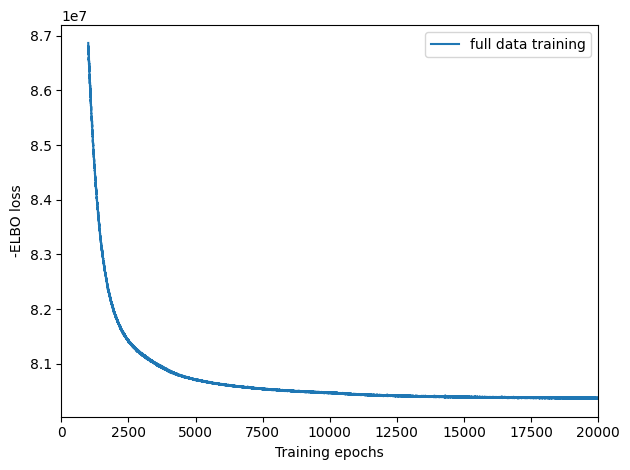

In [8]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])

In [9]:
## save trained model
mod.save(f"{data_dir}/cell2location_map_crop2_chunk1", overwrite=True)

In [10]:
## infer
ad_sp_chunk = mod.export_posterior(ad_sp_chunk, use_quantiles=True, add_to_obsm=['q05'])
q05_df = ad_sp_chunk.obsm['q05_cell_abundance_w_sf']
q05_df.columns = [x.replace('q05cell_abundance_w_sf_', '') for x in q05_df.columns]
q05 = q05_df.values
q05_norm = q05 / q05.sum(1)[:,None]
q05_ct_df = pd.DataFrame(q05_norm, columns = q05_df.columns)
q05_ct_df['cell_type'] = q05_df.columns[q05_df.values.argmax(1)]
q05_ct_df['cell_type'] = q05_ct_df['cell_type'].astype('category')
all_cts = q05_ct_df['cell_type'].cat.categories.tolist()
q05_ct_df['max_abun'] = q05.max(1)
q05_ct_df['max_norm'] = q05_norm.max(1)
q05_ct_df['x'] = ad_sp_chunk.obs['x'].values
q05_ct_df['y'] = ad_sp_chunk.obs['y'].values
q05_ct_df['cell_id'] = ad_sp_chunk.obs['cell_id'].values
q05_ct_df.set_index(ad_sp_chunk.obs.index, inplace=True)
q05_ct_df.groupby('cell_type')['max_norm'].agg(['size', 'median'])

/tmp/ipykernel_1068483/1840773302.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  q05_ct_df.groupby('cell_type')['max_norm'].agg(['size', 'median'])


,size,median
cell_type,,
B_Cycling,2077,0.342711
B_GC_DZ,1251,0.236362
B_GC_LZ,2717,0.294912
B_GC_prePB,323,0.209255
B_IFN,1268,0.260117
B_activated,388,0.211807
B_mem,7931,0.296896
B_naive,1899,0.211070
B_plasma,2149,0.433681


In [11]:
## save qc info
q05_ct_df.to_csv(f'{data_dir}/cell2location_info_crop2_chunk1.csv', sep='\t', index=True)

## Chunk2

In [12]:
ad_sp_chunk = ad_sp[100000:].copy()
intersect = np.intersect1d(ad_sp_chunk.var_names, inf_aver.index)
ad_sp_chunk = ad_sp_chunk[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=ad_sp_chunk)
#scvi.data.view_anndata_setup(adata_vis)
# create and train the model
mod = cell2location.models.Cell2location(
    ad_sp_chunk, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=1,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=20
)
ad_sp_chunk

AnnData object with n_obs × n_vars = 92378 × 2964
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'x', 'y', 'group', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome'
    uns: 'spatialdata_attrs', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'spatial'

In [13]:
mod.train(max_epochs=20000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the

Epoch 20000/20000: 100%|███████████████████████████████████████████████████████████████| 20000/20000 [1:17:51<00:00,  4.28it/s, v_num=1, elbo_train=5.51e+7]

`Trainer.fit` stopped: `max_epochs=20000` reached.



poch 20000/20000: 100%|███████████████████████████████████████████████████████████████| 20000/20000 [1:17:51<00:00,  4.28it/s, v_num=1, elbo_train=5.51e+7]

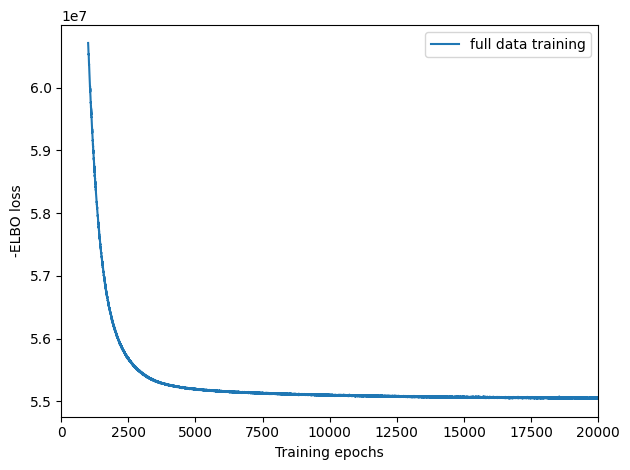

In [14]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])

In [15]:
## save trained model
mod.save(f"{data_dir}/cell2location_map_crop2_chunk2", overwrite=True)

In [16]:
## infer
ad_sp_chunk = mod.export_posterior(ad_sp_chunk, use_quantiles=True, add_to_obsm=['q05'])
q05_df = ad_sp_chunk.obsm['q05_cell_abundance_w_sf']
q05_df.columns = [x.replace('q05cell_abundance_w_sf_', '') for x in q05_df.columns]
q05 = q05_df.values
q05_norm = q05 / q05.sum(1)[:,None]
q05_ct_df = pd.DataFrame(q05_norm, columns = q05_df.columns)
q05_ct_df['cell_type'] = q05_df.columns[q05_df.values.argmax(1)]
q05_ct_df['cell_type'] = q05_ct_df['cell_type'].astype('category')
all_cts = q05_ct_df['cell_type'].cat.categories.tolist()
q05_ct_df['max_abun'] = q05.max(1)
q05_ct_df['max_norm'] = q05_norm.max(1)
q05_ct_df['x'] = ad_sp_chunk.obs['x'].values
q05_ct_df['y'] = ad_sp_chunk.obs['y'].values
q05_ct_df['cell_id'] = ad_sp_chunk.obs['cell_id'].values
q05_ct_df.set_index(ad_sp_chunk.obs.index, inplace=True)
q05_ct_df.groupby('cell_type')['max_norm'].agg(['size', 'median'])

/tmp/ipykernel_1068483/1840773302.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  q05_ct_df.groupby('cell_type')['max_norm'].agg(['size', 'median'])


,size,median
cell_type,,
B_Cycling,2293,0.235434
B_GC_DZ,817,0.179828
B_GC_LZ,1079,0.234076
B_GC_prePB,149,0.172192
B_IFN,910,0.186080
B_activated,374,0.159138
B_mem,3392,0.177353
B_naive,2009,0.145053
B_plasma,5759,0.664787


In [17]:
## save qc info
q05_ct_df.to_csv(f'{data_dir}/cell2location_info_crop2_chunk2.csv', sep='\t', index=True)

# Crop3

In [5]:
## xenium data
ad_sp = sc.read(f'{data_dir}/crop3_raw.h5ad')
ad_sp.var = ad_sp.var.set_index('gene_ids')
intersect = np.intersect1d(ad_sp.var_names, inf_aver.index)
ad_sp = ad_sp[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()
ad_sp

AnnData object with n_obs × n_vars = 223757 × 2964
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'x', 'y', 'group'
    var: 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

## Chunk1

In [7]:
ad_sp_chunk = ad_sp[:115000].copy()
intersect = np.intersect1d(ad_sp_chunk.var_names, inf_aver.index)
ad_sp_chunk = ad_sp_chunk[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=ad_sp_chunk)
#scvi.data.view_anndata_setup(adata_vis)
# create and train the model
mod = cell2location.models.Cell2location(
    ad_sp_chunk, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=1,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=20
)
ad_sp_chunk

AnnData object with n_obs × n_vars = 115000 × 2964
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'x', 'y', 'group', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome'
    uns: 'spatialdata_attrs', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'spatial'

In [ ]:
mod.train(max_epochs=20000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the

Epoch 18881/20000:  94%|███████████████████████████████████████████████████████████▍   | 18881/20000 [1:30:16<05:20,  3.49it/s, v_num=1, elbo_train=9.58e+7]

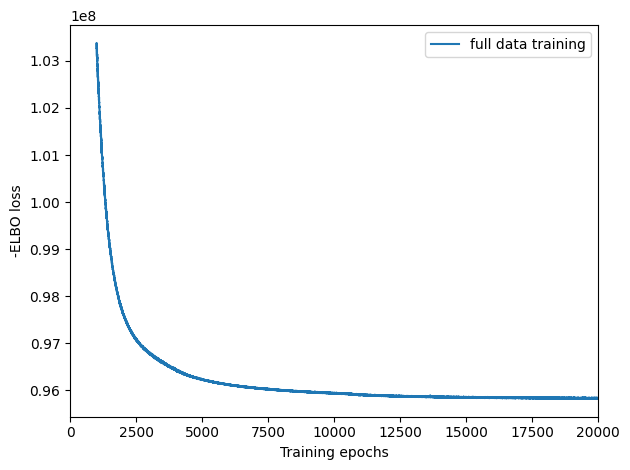

In [9]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])

In [10]:
## save trained model
mod.save(f"{data_dir}/cell2location_map_crop3_chunk1", overwrite=True)

In [16]:
## infer
ad_sp_chunk = mod.export_posterior(ad_sp_chunk, use_quantiles=True, add_to_obsm=['q05'])
q05_df = ad_sp_chunk.obsm['q05_cell_abundance_w_sf']
q05_df.columns = [x.replace('q05cell_abundance_w_sf_', '') for x in q05_df.columns]
q05 = q05_df.values
q05_norm = q05 / q05.sum(1)[:,None]
q05_ct_df = pd.DataFrame(q05_norm, columns = q05_df.columns)
q05_ct_df['cell_type'] = q05_df.columns[q05_df.values.argmax(1)]
q05_ct_df['cell_type'] = q05_ct_df['cell_type'].astype('category')
all_cts = q05_ct_df['cell_type'].cat.categories.tolist()
q05_ct_df['max_abun'] = q05.max(1)
q05_ct_df['max_norm'] = q05_norm.max(1)
q05_ct_df['x'] = ad_sp_chunk.obs['x'].values
q05_ct_df['y'] = ad_sp_chunk.obs['y'].values
q05_ct_df['cell_id'] = ad_sp_chunk.obs['cell_id'].values
q05_ct_df.set_index(ad_sp_chunk.obs.index, inplace=True)
q05_ct_df.groupby('cell_type')['max_norm'].agg(['size', 'median'])

/tmp/ipykernel_970739/2569843488.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  q05_ct_df.groupby('cell_type')['max_norm'].agg(['size', 'median'])


,size,median
cell_type,,
B_Cycling,2024,0.372990
B_GC_DZ,2546,0.426103
B_GC_LZ,4213,0.390076
B_GC_prePB,396,0.238171
B_IFN,1635,0.283874
B_activated,566,0.234070
B_mem,10290,0.344095
B_naive,2684,0.247207
B_plasma,1548,0.393477


In [18]:
## save qc info
q05_ct_df.to_csv(f'{data_dir}/cell2location_info_crop3_chunk1.csv', sep='\t', index=True)

## Chunk2

In [6]:
ad_sp_chunk = ad_sp[115000:].copy()
intersect = np.intersect1d(ad_sp_chunk.var_names, inf_aver.index)
ad_sp_chunk = ad_sp_chunk[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=ad_sp_chunk)
#scvi.data.view_anndata_setup(adata_vis)
# create and train the model
mod = cell2location.models.Cell2location(
    ad_sp_chunk, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=1,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=20
)
ad_sp_chunk

AnnData object with n_obs × n_vars = 108757 × 2964
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'x', 'y', 'group', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome'
    uns: 'spatialdata_attrs', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'spatial'

In [13]:
mod.train(max_epochs=20000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/xiaojiashun/anaconda3/envs/cell2loc_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the

Epoch 20000/20000: 100%|███████████████████████████████████████████████████████████████| 20000/20000 [1:30:39<00:00,  3.68it/s, v_num=1, elbo_train=6.95e+7]

`Trainer.fit` stopped: `max_epochs=20000` reached.



poch 20000/20000: 100%|███████████████████████████████████████████████████████████████| 20000/20000 [1:30:39<00:00,  3.68it/s, v_num=1, elbo_train=6.95e+7]

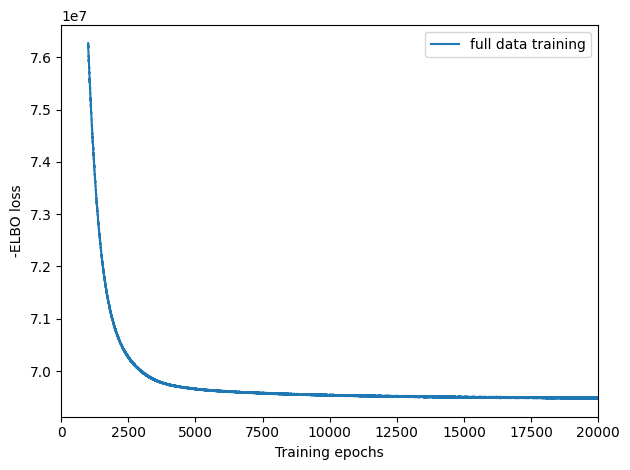

In [14]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])

In [15]:
## save trained model
mod.save(f"{data_dir}/cell2location_map_crop3_chunk2", overwrite=True)

In [16]:
## infer
ad_sp_chunk = mod.export_posterior(ad_sp_chunk, use_quantiles=True, add_to_obsm=['q05'])
q05_df = ad_sp_chunk.obsm['q05_cell_abundance_w_sf']
q05_df.columns = [x.replace('q05cell_abundance_w_sf_', '') for x in q05_df.columns]
q05 = q05_df.values
q05_norm = q05 / q05.sum(1)[:,None]
q05_ct_df = pd.DataFrame(q05_norm, columns = q05_df.columns)
q05_ct_df['cell_type'] = q05_df.columns[q05_df.values.argmax(1)]
q05_ct_df['cell_type'] = q05_ct_df['cell_type'].astype('category')
all_cts = q05_ct_df['cell_type'].cat.categories.tolist()
q05_ct_df['max_abun'] = q05.max(1)
q05_ct_df['max_norm'] = q05_norm.max(1)
q05_ct_df['x'] = ad_sp_chunk.obs['x'].values
q05_ct_df['y'] = ad_sp_chunk.obs['y'].values
q05_ct_df['cell_id'] = ad_sp_chunk.obs['cell_id'].values
q05_ct_df.set_index(ad_sp_chunk.obs.index, inplace=True)
q05_ct_df.groupby('cell_type')['max_norm'].agg(['size', 'median'])

/tmp/ipykernel_991896/1840773302.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  q05_ct_df.groupby('cell_type')['max_norm'].agg(['size', 'median'])


,size,median
cell_type,,
B_Cycling,2664,0.276757
B_GC_DZ,2464,0.455406
B_GC_LZ,3701,0.517601
B_GC_prePB,336,0.266923
B_IFN,1231,0.211145
B_activated,483,0.187523
B_mem,5843,0.216895
B_naive,2470,0.172650
B_plasma,4028,0.671174


In [17]:
## save qc info
q05_ct_df.to_csv(f'{data_dir}/cell2location_info_crop3_chunk2.csv', sep='\t', index=True)